# Modeling KMeans, KAgglomerativeClustering, Annoy

## Imports

In [5]:
pip install --user annoy

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import pickle as pkl
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from annoy import AnnoyIndex
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans # import from sklearn
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

## Pickle Load and Helper Functions

In [36]:
df_for_brands = pkl.load(open('df_pickles/df_reg_1.p','rb'))

In [37]:
df_for_brands.drop('price',1,inplace=True)

In [38]:
df_for_brands_gas = df_for_brands[df_for_brands['Engine type']!='Electric']

In [39]:
df_for_brands_elec = df_for_brands[df_for_brands['Engine type']=='Electric']

In [40]:
prices = pkl.load(open('df_pickles/prices.p','rb'))

In [41]:
df_for_brands_gas = pd.concat([df_for_brands_gas, prices],1)

In [42]:
## GAS ##

In [43]:
df_gas = pkl.load(open('df_pickles/df_gas_sc_dmd.p','rb'))

In [44]:
df_gas_mod = df_gas.drop(['model', 'front_suspension_type_1',
       'front_suspension_type_2', 'front_suspension_type_3',
       'front_suspension_type_4', 'front_suspension_type_5',
       'front_suspension_type_6', 'front_suspension_type_7',
       'front_suspension_type_8', 'front_suspension_type_9', 
        'front_suspension_type_10', 'front_suspension_type_11',
       'front_suspension_type_12', 'front_wheel_diameter_15',
       'front_wheel_diameter_16', 'front_wheel_diameter_17',
       'front_wheel_diameter_18', 'front_wheel_diameter_19',
       'front_wheel_diameter_20', 'front_wheel_diameter_21',
       'front_wheel_diameter_22', 'rear_suspension_type_1',
       'rear_suspension_type_2', 'rear_suspension_type_3',
       'rear_suspension_type_4', 'rear_suspension_type_5', 
                          'rear_suspension_type_6',
       'rear_suspension_type_7', 'rear_suspension_type_8',
       'rear_suspension_type_9', 'rear_suspension_type_10',
       'rear_wheel_diameter_15', 'rear_wheel_diameter_16',
       'rear_wheel_diameter_17', 'rear_wheel_diameter_18',
       'rear_wheel_diameter_19', 'rear_wheel_diameter_20',
       'rear_wheel_diameter_21', 'rear_wheel_diameter_22',
                         'brand_1',
       'brand_2', 'brand_3', 'brand_4', 'brand_5', 'brand_6', 'brand_7',
       'brand_8', 'brand_9', 'brand_10', 'brand_11', 'brand_12', 'brand_13',
       'brand_14', 'brand_15', 'brand_16', 'brand_17', 'brand_18', 'brand_19',
       'brand_20', 'brand_21', 'brand_22', 'brand_23', 'brand_24', 'brand_25',
       'brand_26', 'brand_27', 'brand_28', 'brand_29', 'brand_30', 'brand_31',
       'brand_32', 'brand_33', 'brand_34', 'brand_35', 'brand_36', 'brand_37',
       'brand_39', 'brand_40', 'brand_41'], 1)

In [45]:
## ELEC

In [46]:
df_elec = pkl.load(open('df_pickles/df_elec_sc_dmd.p','rb'))

In [47]:
df_elec.columns[20:]

Index(['passenger_doors_487', 'passenger_doors_687', 'passenger_doors_1013',
       'passenger_capacity_4', 'passenger_capacity_5',
       'passenger_capacity_354', 'passenger_capacity_382',
       'passenger_capacity_443', 'passenger_capacity_485',
       'passenger_capacity_486', 'passenger_capacity_487',
       'passenger_capacity_687', 'passenger_capacity_1013', 'engine_type_354',
       'engine_type_382', 'engine_type_443', 'engine_type_485',
       'engine_type_486', 'engine_type_487', 'engine_type_687',
       'engine_type_1013', 'drive_type_2', 'drive_type_3', 'drive_type_354',
       'drive_type_382', 'drive_type_443', 'drive_type_485', 'drive_type_486',
       'drive_type_487', 'drive_type_687', 'drive_type_1013',
       'front_suspension_type_6', 'front_suspension_type_354',
       'front_suspension_type_382', 'front_suspension_type_443',
       'front_suspension_type_485', 'front_suspension_type_486',
       'front_suspension_type_487', 'front_suspension_type_687',
       '

In [48]:
df_elec_mod = df_elec.drop(['model', 'front_suspension_type_6', 'front_suspension_type_354',
       'front_suspension_type_382', 'front_suspension_type_443',
       'front_suspension_type_485', 'front_suspension_type_486',
       'front_suspension_type_487', 'front_suspension_type_687',
       'front_suspension_type_1013', 'front_wheel_diameter_16.0',
       'front_wheel_diameter_17.0', 'front_wheel_diameter_18.0',
       'front_wheel_diameter_19.0', 'front_wheel_diameter_20.0',
       'front_wheel_diameter_354.0', 'front_wheel_diameter_382.0',
       'front_wheel_diameter_443.0', 'front_wheel_diameter_485.0',
       'front_wheel_diameter_486.0', 'front_wheel_diameter_487.0',
       'front_wheel_diameter_687.0', 'front_wheel_diameter_1013.0',
       'rear_suspension_type_6', 'rear_suspension_type_9',
       'rear_suspension_type_354', 'rear_suspension_type_382',
       'rear_suspension_type_443', 'rear_suspension_type_485',
       'rear_suspension_type_486', 'rear_suspension_type_487',
       'rear_suspension_type_687', 'rear_suspension_type_1013',
       'rear_wheel_diameter_16.0', 'rear_wheel_diameter_17.0',
       'rear_wheel_diameter_18.0', 'rear_wheel_diameter_19.0',
       'rear_wheel_diameter_20.0', 'rear_wheel_diameter_354.0',
       'rear_wheel_diameter_382.0', 'rear_wheel_diameter_443.0',
       'rear_wheel_diameter_485.0', 'rear_wheel_diameter_486.0',
       'rear_wheel_diameter_487.0', 'rear_wheel_diameter_687.0',
       'rear_wheel_diameter_1013.0', 'brand_11', 'brand_16', 'brand_17',
       'brand_19', 'brand_21', 'brand_33', 'brand_38', 'brand_39', 'brand_40',
       'brand_42', 'brand_354', 'brand_382', 'brand_443', 'brand_485',
       'brand_486', 'brand_487', 'brand_687', 'brand_1013'], 1)

In [49]:
df_gas_mod.columns

Index(['price', 'base_engine_size', 'fuel_tank_capacity',
       'epa_mileage_combined', 'Horsepower', 'Torque', 'third_row_seating',
       'first_row_seating', 'rear_row_seating', 'curb_weight', 'Height',
       'Wheelbase', 'Width', 'gear_ratios', 'passenger_doors_3',
       'passenger_doors_4', 'passenger_capacity_3', 'passenger_capacity_4',
       'passenger_capacity_5', 'passenger_capacity_6', 'passenger_capacity_7',
       'passenger_capacity_8', 'passenger_capacity_9', 'passenger_capacity_12',
       'passenger_capacity_15', 'Cylinders_4.0', 'Cylinders_5.0',
       'Cylinders_6.0', 'Cylinders_8.0', 'Cylinders_10.0', 'Cylinders_12.0',
       'engine_type_2', 'drive_type_1', 'drive_type_2', 'drive_type_3'],
      dtype='object')

In [50]:
def threed_figures(model, df):
    fignum = 1
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = model.labels_

    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'].astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title(str(model))
    ax.dist = 12

    # Plot the ground truth
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#     for name, label in [('PCA1', 0), ('PCA2', 1), ('PCA3', 2)]:
#         ax.text3D(df[y == label, 3].mean(),
#                   df[y == label, 0].mean(),
#                   df[y == label, 2].mean() + 2, name,
#                   horizontalalignment='center',
#                   bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
    #Reorder the labels to have colors matching the cluster results
#    y = np.choose(df['labels'], [1, 2, 0]).astype(np.float)
    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'], edgecolor='k',cmap='hsv',s=16)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('Car Cluster Representation After Reducing Dimension to 3D')
    ax.dist = 12

    fig.show();

In [51]:
pca = PCA(n_components=3)

## KMeans

In [52]:
k_means = KMeans(n_clusters=30, n_init=20, max_iter=1500)
k_means.fit(df_gas_mod)
cluster_assignments = k_means.predict(df_gas_mod)

In [53]:
labels = k_means.labels_

In [54]:
df_gas_mod_kmeans = df_gas_mod.copy()

In [55]:
df_gas_mod_kmeans['labels'] = cluster_assignments

In [56]:
df_gas_mod_kmeans[0:5];

In [57]:
kmeans_ft_pca = pca.fit_transform((df_gas_mod_kmeans.iloc[:,:-1]))
df_gas_mod_kmeans['x']=kmeans_ft_pca[:,0]
df_gas_mod_kmeans['y']=kmeans_ft_pca[:,1]
df_gas_mod_kmeans['z']=kmeans_ft_pca[:,2]
pca.components_.shape

(3, 35)

In [95]:
df_gas_mod_kmeans[df_gas_mod_kmeans['labels']==23]

price base_engine_size  \
/cars/2019/ford/f-150/79212                    0.121050              3.5   
/cars/2019/ford/f-150/79217                    0.084162              3.5   
/cars/2019/ford/f-150/79218                    0.090382              3.5   
/cars/2019/gmc/canyon/78326                    0.052587              3.6   
/cars/2019/gmc/canyon/78327                    0.055504              3.6   
/cars/2019/gmc/canyon/78328                    0.065296              3.6   
/cars/2019/gmc/canyon/78329                    0.048837              3.6   
/cars/2019/gmc/canyon/78330                    0.055712              3.6   
/cars/2019/gmc/canyon/78331                    0.053212              3.6   
/cars/2019/gmc/canyon/78332                    0.056129              3.6   
/cars/2019/gmc/canyon/78333                    0.065921              3.6   
/cars/2019/gmc/canyon/78334                    0.049462              3.6   
/cars/2019/gmc/canyon/78335                    0.056337              3.6   
/cars/2019/jeep/cherokee/78548                 0.045805              3.2   
/cars/2019/jeep/cherokee/78551                 0.028825              3.2   
/cars/2019/jeep/cherokee/78554                 0.044399              3.2   
/cars/2019/jeep/cherokee/78556                 0.052743              3.2   
/cars/2019/jeep/cherokee/78558                 0.043774              3.2   
/cars/2019/jeep/cherokee/78559                 0.043774              3.2   
/cars/2019/jeep/grand-cherokee/78571           0.044243              3.6   
/cars/2019/jeep/grand-cherokee/78573           0.074974              3.6   
/cars/2019/jeep/grand-cherokee/78575           0.044243              3.6   
/cars/2019/jeep/grand-cherokee/78577           0.044243              3.6   
/cars/2019/jeep/grand-cherokee/78579           0.058723              3.6   
/cars/2019/jeep/grand-cherokee/78581           0.058723              3.6   
/cars/2019/jeep/grand-cherokee/78583           0.074974              3.6   
/cars/2019/jeep/grand-cherokee/78586           0.086850              3.6   
/cars/2019/jeep/grand-cherokee/78588           0.065182              3.6   
/cars/2019/jeep/wrangler/79477                 0.054035              3.6   
/cars/2019/jeep/wrangler/79479                 0.054035              3.6   
...                                                 ...              ...   
/cars/2019/land-rover/range-rover-velar/79540  0.110716                3   
/cars/2019/land-rover/range-rover-velar/79541  0.101549                3   
/cars/2019/nissan/frontier/79739               0.045482                4   
/cars/2019/nissan/frontier/79740               0.043295                4   
/cars/2019/nissan/frontier/79741               0.035482                4   
/cars/2019/nissan/frontier/79742               0.051025                4   
/cars/2019/nissan/frontier/79744               0.036628                4   
/cars/2019/nissan/frontier/79743               0.037503                4   
/cars/2019/nissan/frontier/79745               0.042545                4   
/cars/2019/nissan/frontier/79751               0.043899                4   
/cars/2019/nissan/frontier/79752               0.033648                4   
/cars/2019/ram/1500/78886                      0.085913              3.6   
/cars/2019/ram/1500/78882                      0.091121              3.6   
/cars/2019/ram/1500/78883                      0.091746              3.6   
/cars/2019/toyota/4runner/78940                0.068338                4   
/cars/2019/toyota/4runner/78942                0.071964                4   
/cars/2019/toyota/4runner/78944                0.050681                4   
/cars/2019/toyota/4runner/78946                0.054494                4   
/cars/2019/toyota/4runner/78947                0.053389                4   
/cars/2019/toyota/4runner/78948                0.057369                4   
/cars/2019/toyota/4runner/78949                0.070745                4   
/cars/2019/toyota/taco

In [79]:
import plotly.express as px
fig = px.scatter_3d(df_gas_mod_kmeans, x='x', y='y', z='z', color='labels')
fig.show()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


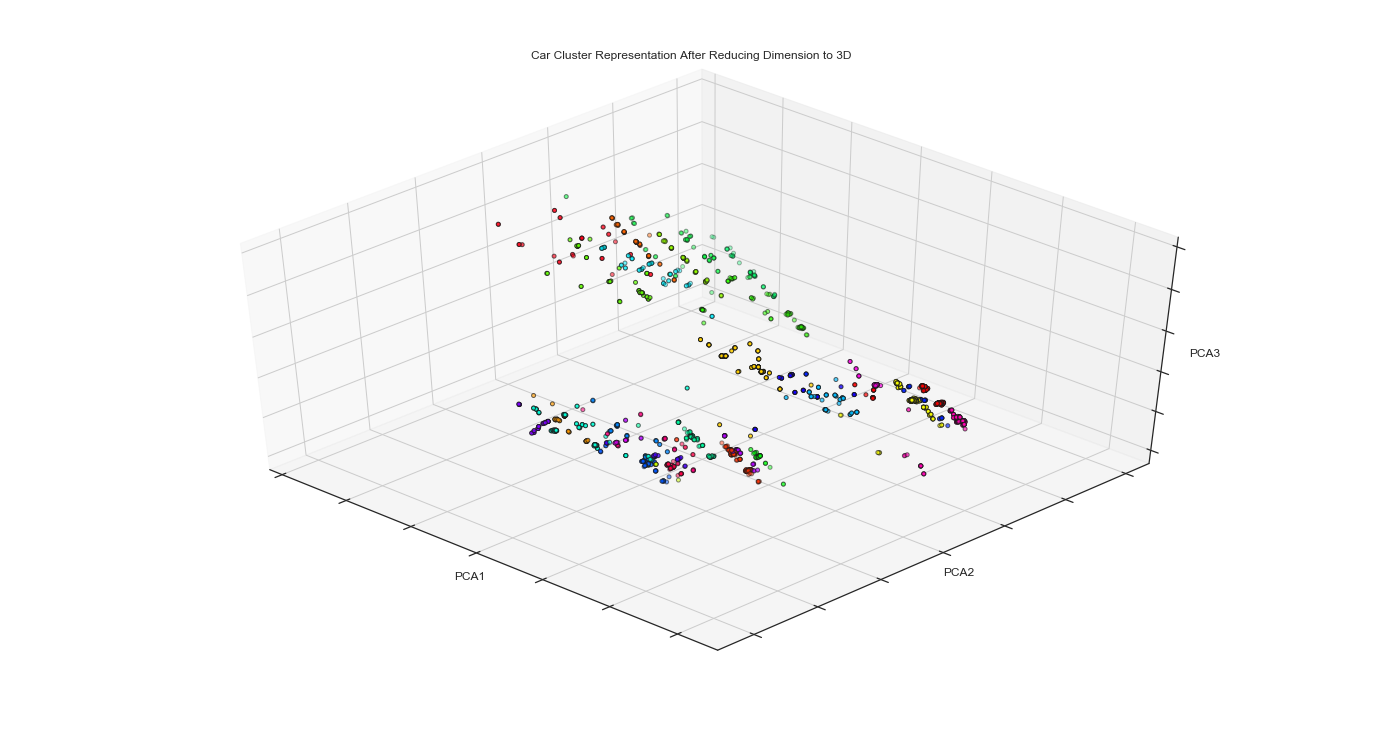

In [58]:
threed_figures(k_means, df_gas_mod_kmeans)

In [59]:
# Generate silhouette coefficient for each k
X = df_gas_mod_kmeans.copy()
silhouette_plot = []
for k in range(20, 80):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

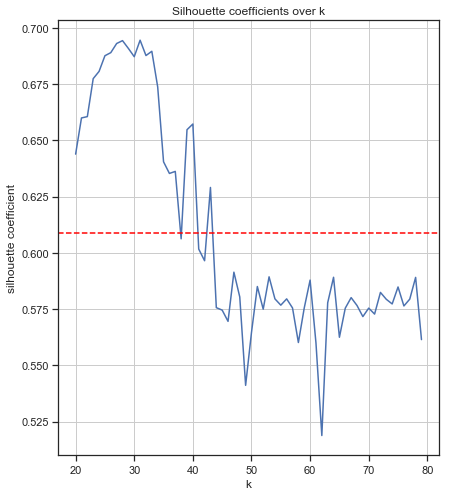

In [60]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 80), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

## AgglomerativeClustering

### Linkage = Single

In [25]:
df_gas_hac_single = df_gas_mod.copy()

In [26]:
agg_clust_single = AgglomerativeClustering(linkage='single', n_clusters=30)
assigned_clust_single = agg_clust_single.fit_predict(df_gas_hac_single)
df_gas_hac_single['labels'] = assigned_clust_single

In [27]:
hac_single_ft_pca = pca.fit_transform((df_gas_hac_single.iloc[:,:-1]))
df_gas_hac_single['x']=hac_single_ft_pca[:,0]
df_gas_hac_single['y']=hac_single_ft_pca[:,1]
df_gas_hac_single['z']=hac_single_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


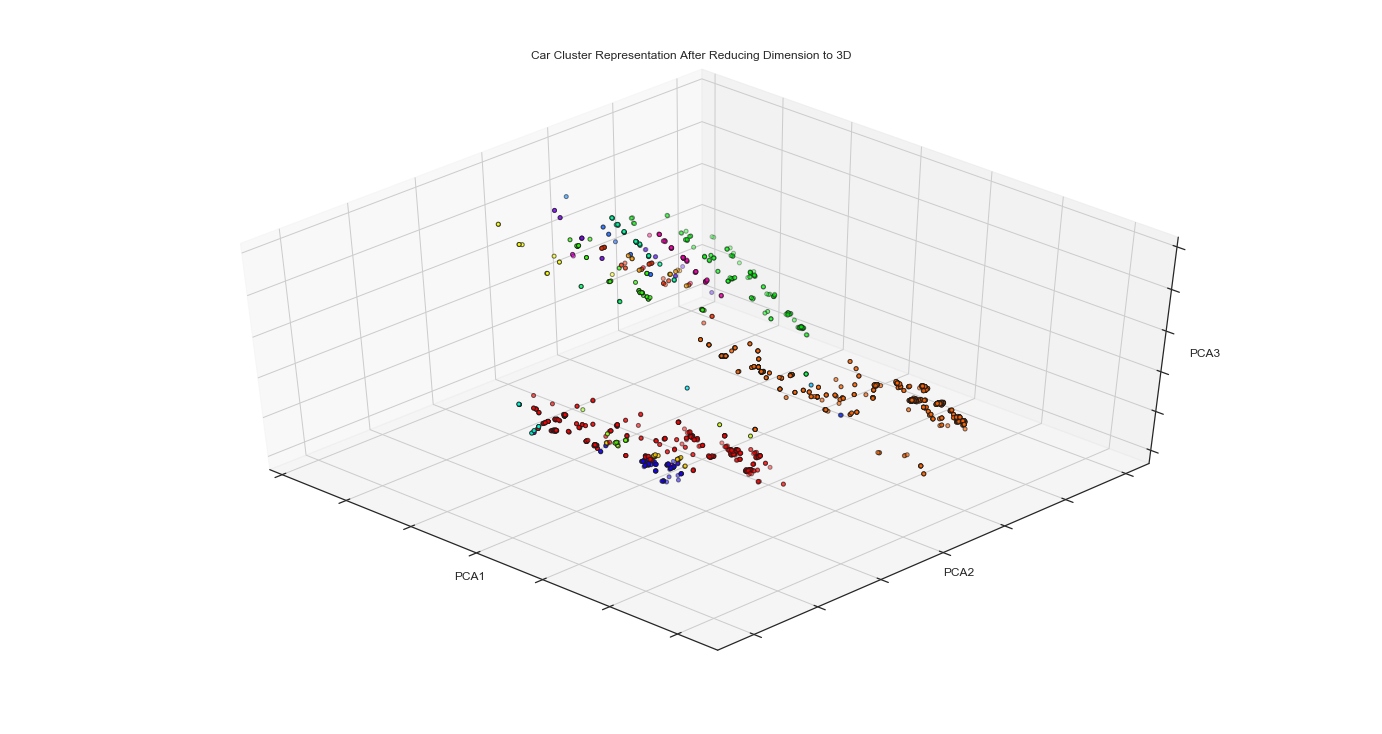

In [28]:
threed_figures(agg_clust_single, df_gas_hac_single)

### Linkage = Complete

In [29]:
df_gas_hac_complete = df_gas_mod.copy()

In [30]:
agg_clust_complete = AgglomerativeClustering(linkage='complete', n_clusters=30)
assigned_clust_complete = agg_clust_complete.fit_predict(df_gas_hac_complete)
df_gas_hac_complete['labels'] = assigned_clust_complete

In [31]:
hac_comp_ft_pca = pca.fit_transform((df_gas_hac_complete.iloc[:,:-1]))
df_gas_hac_complete['x']=hac_comp_ft_pca[:,0]
df_gas_hac_complete['y']=hac_comp_ft_pca[:,1]
df_gas_hac_complete['z']=hac_comp_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


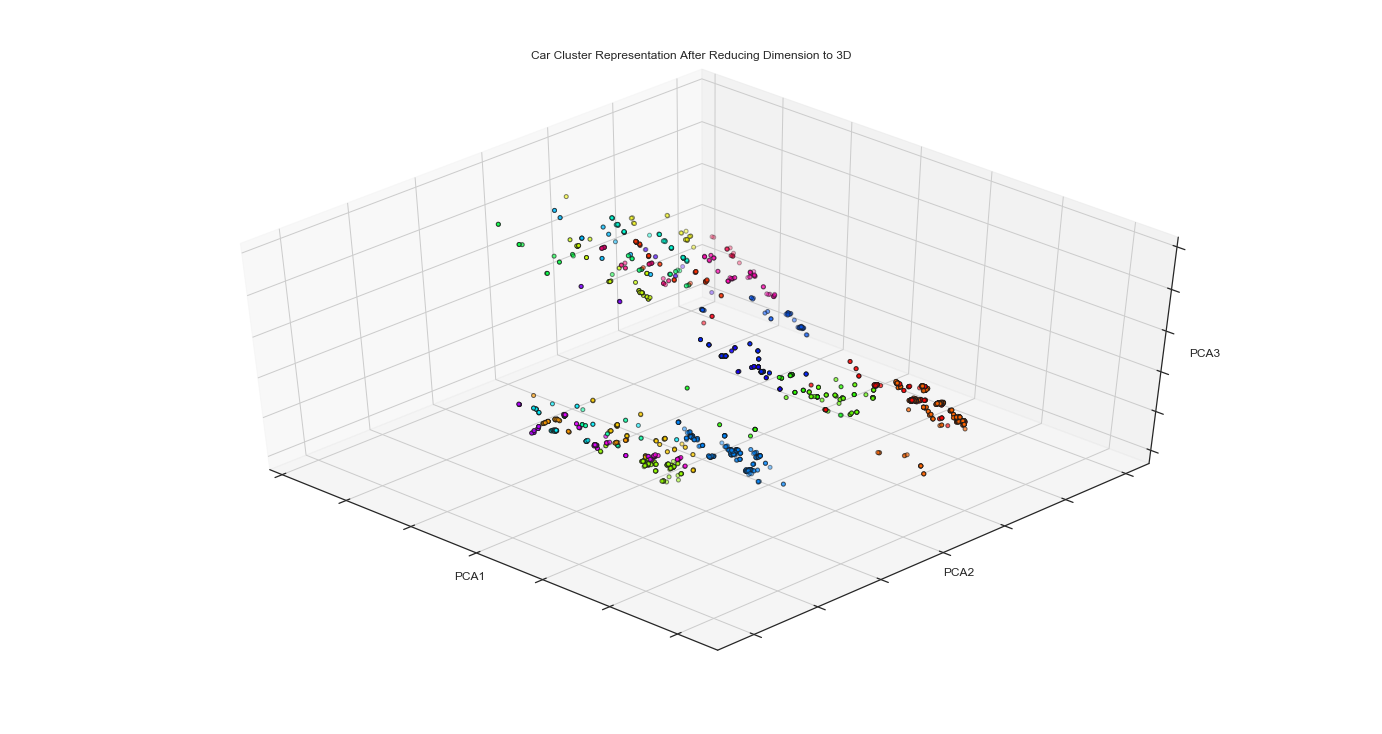

In [32]:
threed_figures(agg_clust_complete, df_gas_hac_complete)

### Linkage = Average

In [33]:
df_gas_hac_avg = df_gas_mod.copy()

In [34]:
agg_clust_avg = AgglomerativeClustering(linkage='average', n_clusters=30)
assigned_clust_avg = agg_clust_avg.fit_predict(df_gas_hac_avg)
df_gas_hac_avg['labels'] = assigned_clust_avg

In [35]:
hac_avg_ft_pca = pca.fit_transform((df_gas_hac_avg.iloc[:,:-1]))
df_gas_hac_avg['x']=hac_avg_ft_pca[:,0]
df_gas_hac_avg['y']=hac_avg_ft_pca[:,1]
df_gas_hac_avg['z']=hac_avg_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


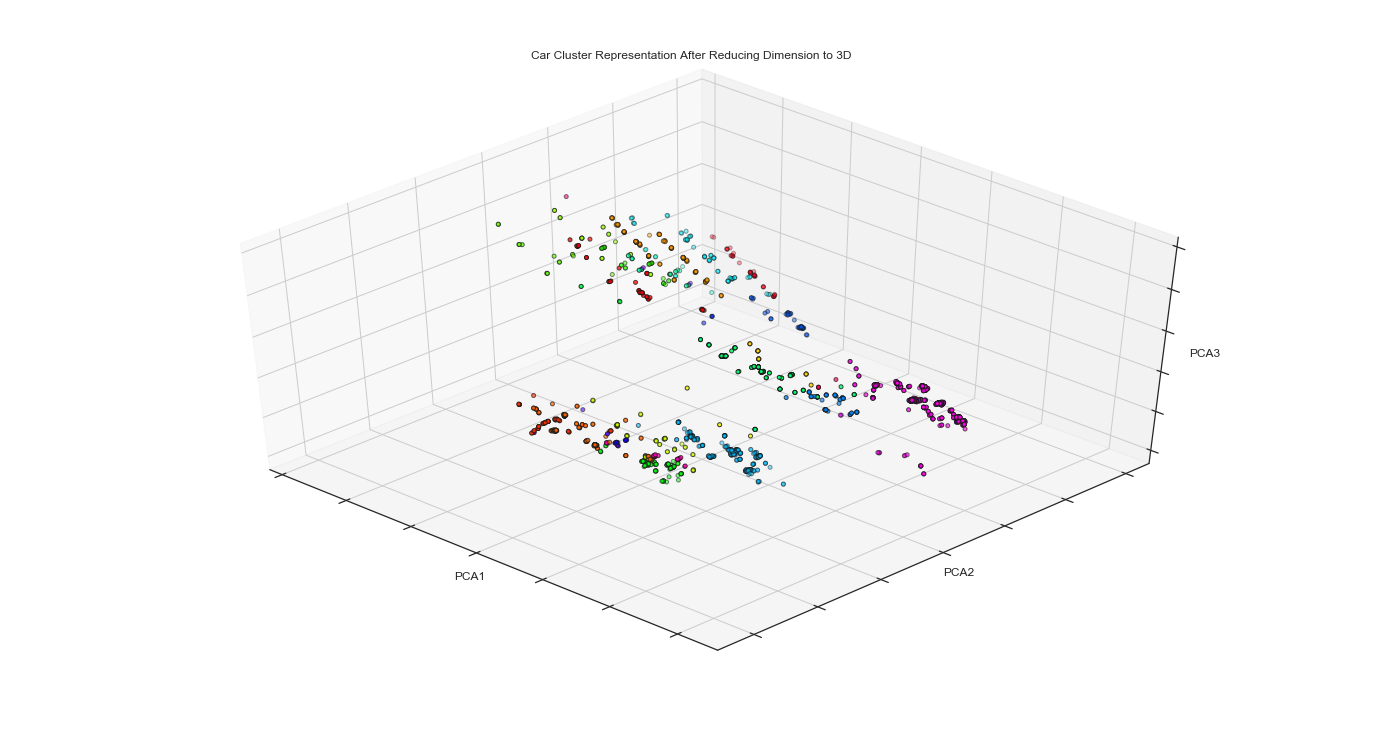

In [36]:
threed_figures(agg_clust_avg, df_gas_hac_avg)

### Linkage = Ward

In [81]:
df_gas_hac_ward = df_gas_mod.copy()

In [82]:
df_gas_hac_ward.iloc[:5,:-2];

In [83]:
agg_clust_ward = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward = agg_clust_ward.fit_predict(df_gas_hac_ward)
df_gas_hac_ward['labels'] = assigned_clust_ward

In [84]:
assigned_clust_ward

array([6, 6, 6, ..., 9, 9, 9])

In [85]:
hac_ward_ft_pca = pca.fit_transform((df_gas_hac_ward.iloc[:,:-1]))
df_gas_hac_ward['x']=hac_ward_ft_pca[:,0]
df_gas_hac_ward['y']=hac_ward_ft_pca[:,1]
df_gas_hac_ward['z']=hac_ward_ft_pca[:,2]

In [91]:
df_gas_hac_ward[df_gas_hac_ward['labels'] == 24]

price base_engine_size  \
/cars/2019/acura/rlx/79094            0.088423              3.5   
/cars/2019/acura/tlx/77647            0.049462              3.5   
/cars/2019/acura/tlx/77644            0.063213              3.5   
/cars/2019/acura/tlx/77643            0.063213              3.5   
/cars/2019/acura/tlx/77645            0.065609              3.5   
/cars/2019/acura/tlx/77646            0.057588              3.5   
/cars/2019/buick/lacrosse/77826       0.067526              3.6   
/cars/2019/buick/lacrosse/77833       0.056067              3.6   
/cars/2019/cadillac/xt5/77895         0.060911              3.6   
/cars/2019/cadillac/xt5/77893         0.075078              3.6   
/cars/2019/cadillac/xt5/77894         0.086954              3.6   
/cars/2019/ford/taurus/78227          0.051775              3.5   
/cars/2019/ford/taurus/78228          0.031961              3.5   
/cars/2019/ford/taurus/78230          0.037024              3.5   
/cars/2019/honda/passport/79308       0.049899              3.5   
/cars/2019/honda/passport/79305       0.040690              3.5   
/cars/2019/honda/passport/79311       0.055879              3.5   
/cars/2019/honda/ridgeline/78466      0.036523              3.5   
/cars/2019/honda/ridgeline/78467      0.046691              3.5   
/cars/2019/honda/ridgeline/78470      0.051129              3.5   
/cars/2019/honda/ridgeline/78472      0.043607              3.5   
/cars/2019/jeep/cherokee/78557        0.049618              3.2   
/cars/2019/jeep/grand-cherokee/78590  0.044243              3.6   
/cars/2019/kia/cadenza/79485          0.065921              3.3   
/cars/2019/kia/cadenza/79484          0.043003              3.3   
/cars/2019/kia/cadenza/79486          0.053629              3.3   
/cars/2019/lexus/es/78656             0.065786              3.5   
/cars/2019/lexus/es/78657             0.061869              3.5   
/cars/2019/lexus/es/78652             0.056337              3.5   
/cars/2019/lexus/es/78658             0.063942              3.5   
/cars/2019/lexus/rx/78673             0.076589              3.5   
/cars/2019/lexus/rx/78674             0.064817              3.5   
/cars/2019/lincoln/continental/78684  0.119977              2.7   
/cars/2019/lincoln/continental/78686  0.070182              3.7   
/cars/2019/lincoln/continental/78688  0.098445              2.7   
/cars/2019/lincoln/continental/78690  0.078099              3.7   
/cars/2019/nissan/maxima/79767        0.060588              3.5   
/cars/2019/nissan/maxima/79766        0.044982              3.5   
/cars/2019/nissan/maxima/79768        0.054337              3.5   
/cars/2019/nissan/maxima/79769        0.056608              3.5   
/cars/2019/nissan/maxima/79770        0.049170              3.5   
/cars/2019/nissan/murano/79776        0.064942              3.5   
/cars/2019/nissan/murano/79775        0.039399              3.5   
/cars/2019/nissan/murano/79777        0.055983              3.5   
/cars/2019/nissan/murano/79778        0.046003              3.5   
/cars/2019/toyota/avalon/78958        0.061129              3.5   
/cars/2019/toyota/avalon/78959        0.061963              3.5   
/cars/2019/toyota/avalon/78960        0.048004              3.5   
/cars/2019/toyota/avalon/78961        0.053212              3.5   
/cars/2019/toyota/camry/78972         0.044982              3.5   
/cars/2019/toyota/camry/78974         0.046128              3.5   

                                      fuel_tank_capacity  \
/cars/2019/acura/rlx/79094                      0.280488   
/cars/2019/acura/tlx/77647                      0.248780   
/cars/2019/acura/tlx/77644                      0.248780   
/cars/2019/acura/tlx/77643                      0.248780   
/cars/2019/acura/tlx/77645                      0.248780   
/cars/2019/acura/tlx/77646                      0.248780   
/cars/2019/buick/lacrosse/77826                 0.214634   
/cars/2019/buick/lacrosse/77833                 0.214634   
/cars/2019/cadil

In [86]:
import plotly.express as px
fig = px.scatter_3d(df_gas_hac_ward, x='x', y='y', z='z', color='labels')
fig.show()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


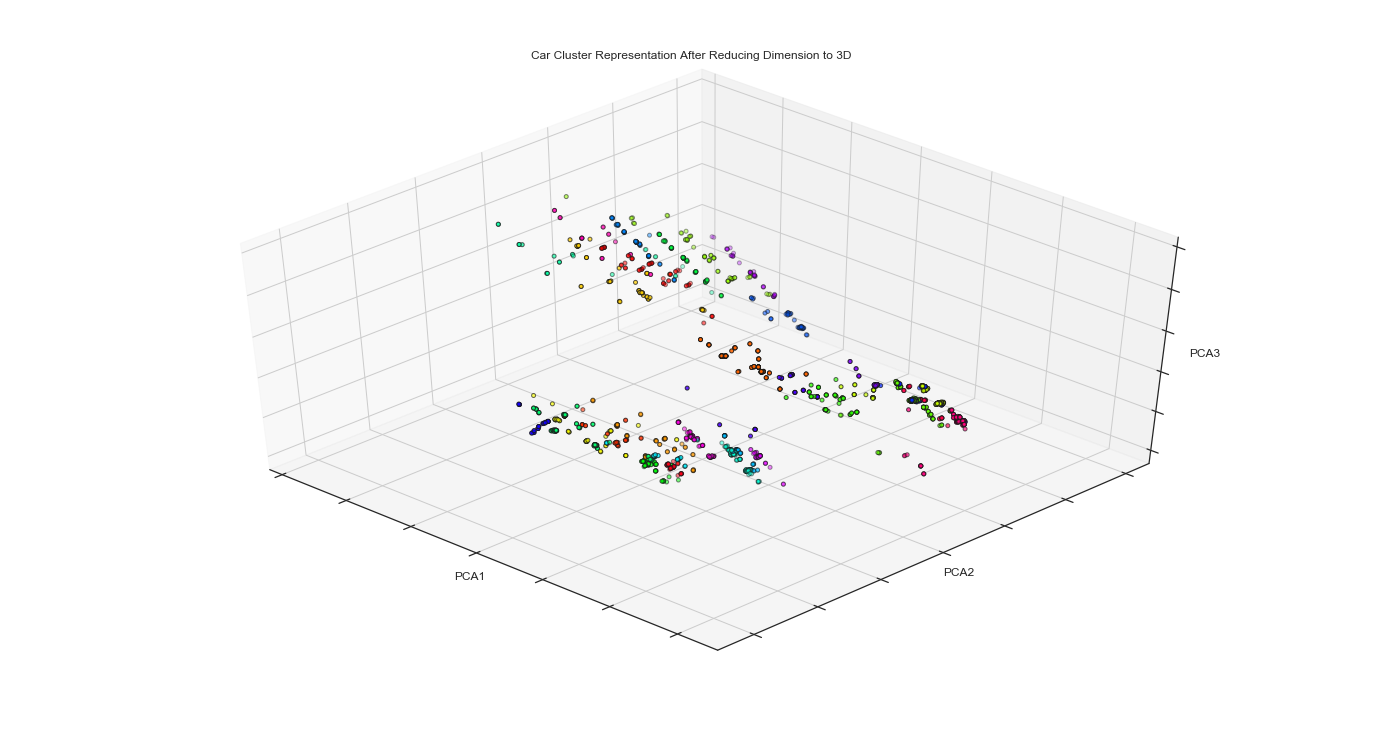

In [42]:
threed_figures(agg_clust_ward, df_gas_hac_ward)

In [49]:
# Generate silhouette coefficient for each k
X = df_gas_hac_ward.copy()
silhouette_plot = []
for k in range(30, 80):
    clusters = AgglomerativeClustering(linkage='ward', n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

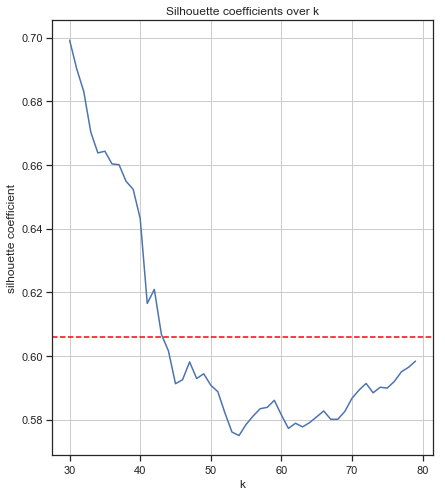

In [51]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(30, 80), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

### Dendograms, calinski_harabaz_score and silhouette_score

#### Dendograms

Text(0, 0.5, 'Cluster distance')

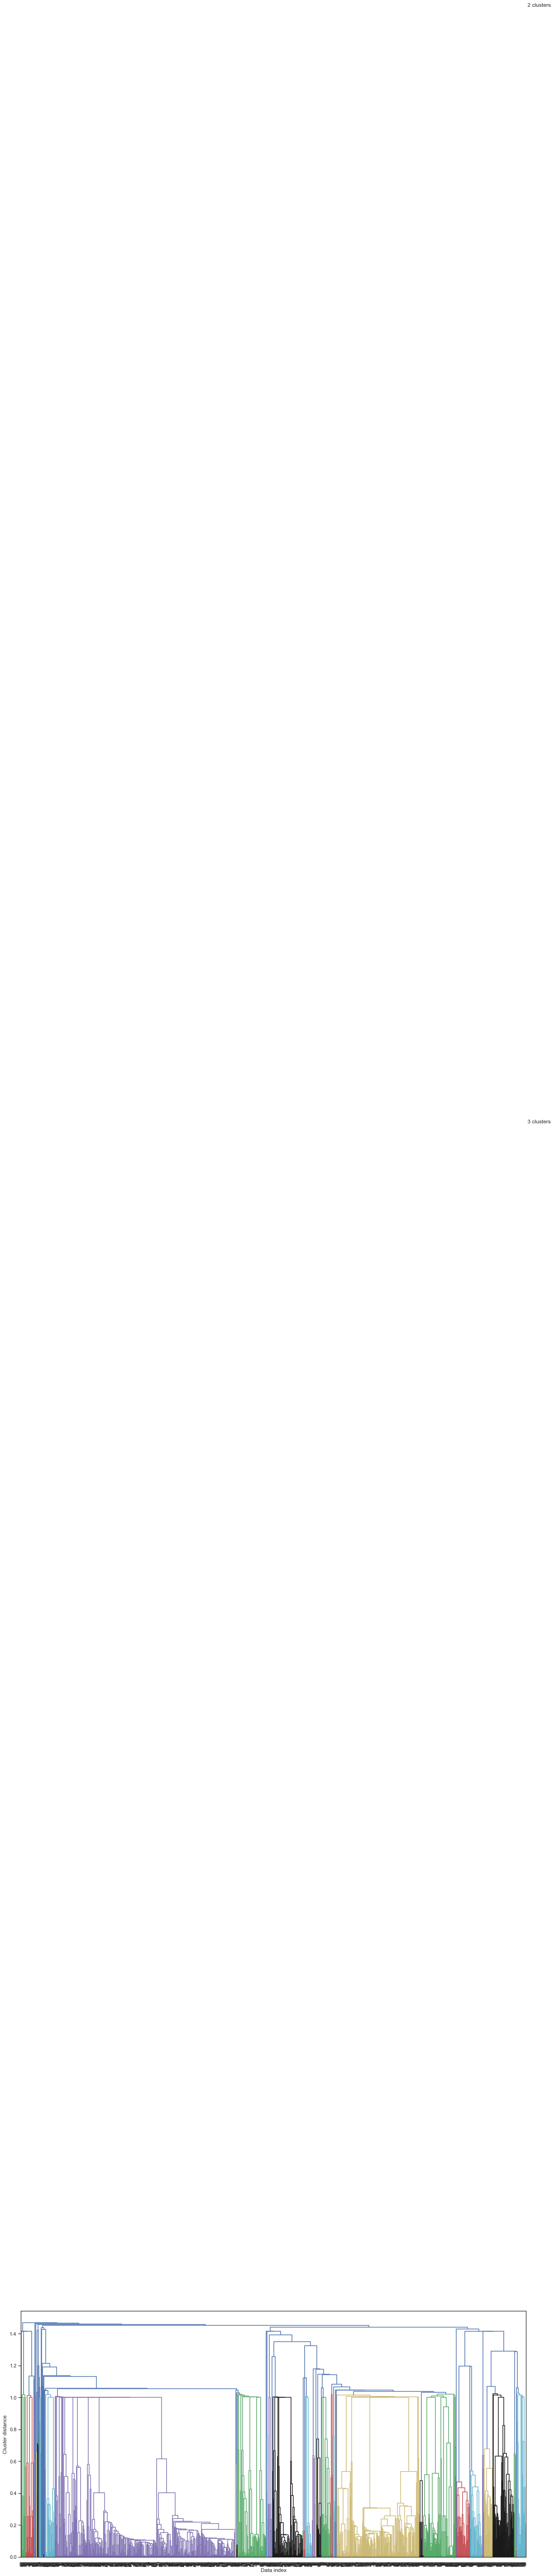

In [53]:
plt.figure(figsize=(20,10))
linkage_array = single(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

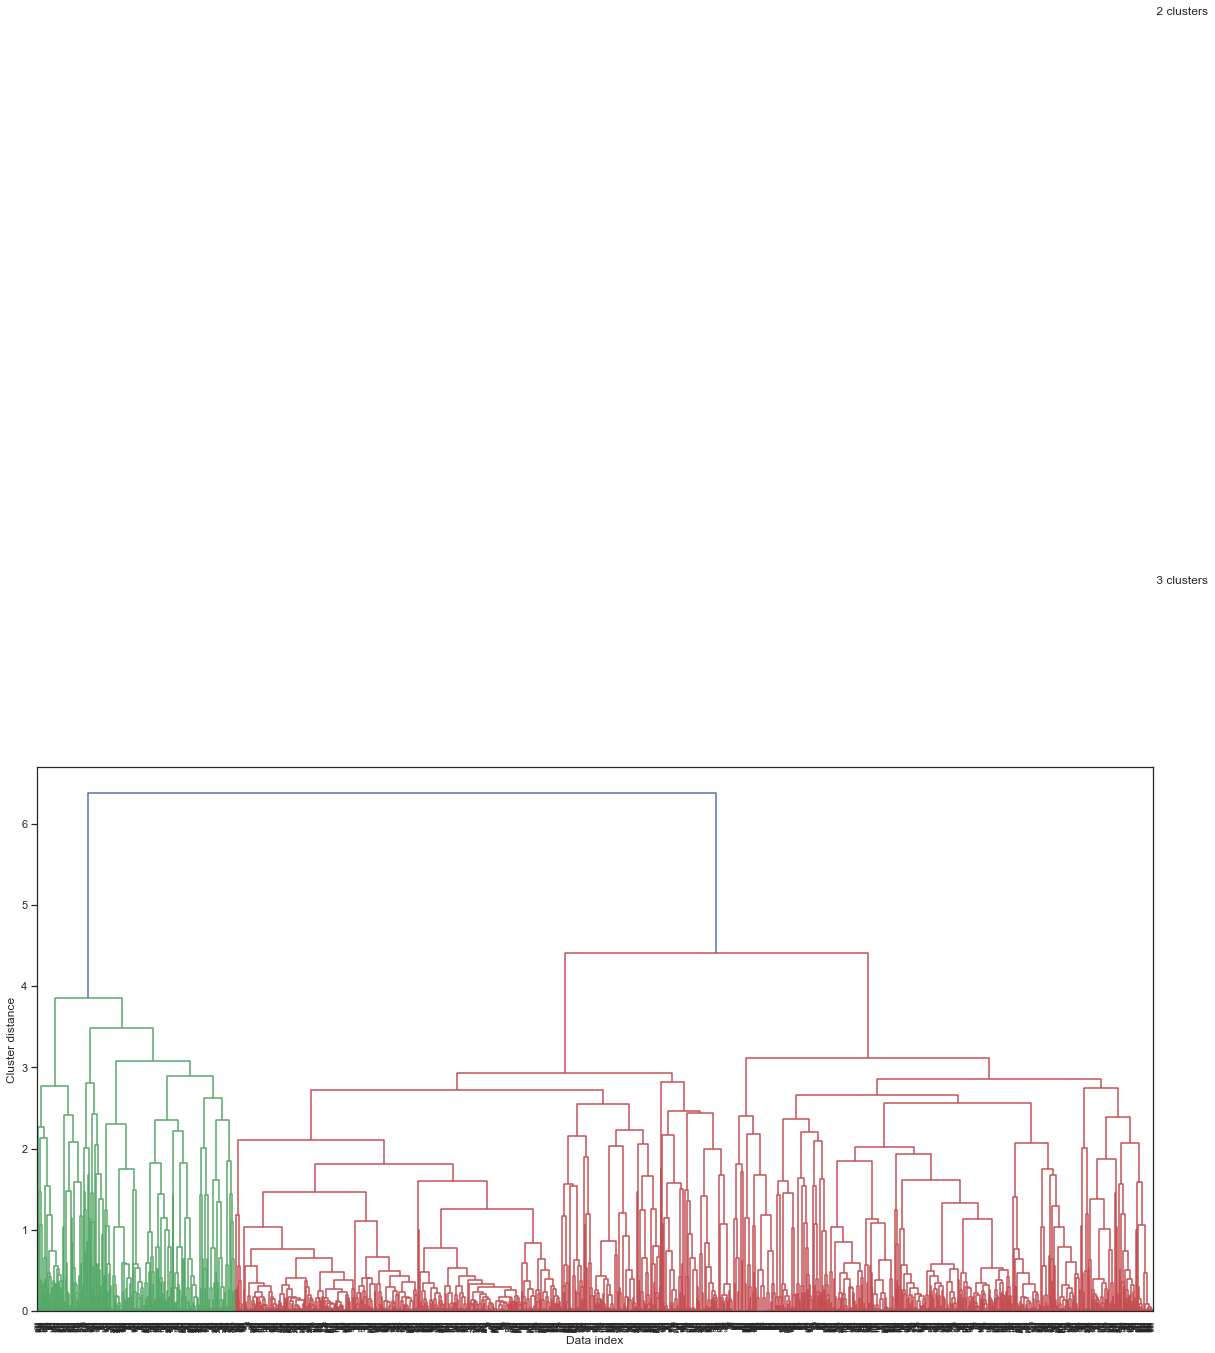

In [54]:
plt.figure(figsize=(20,10))
linkage_array = complete(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

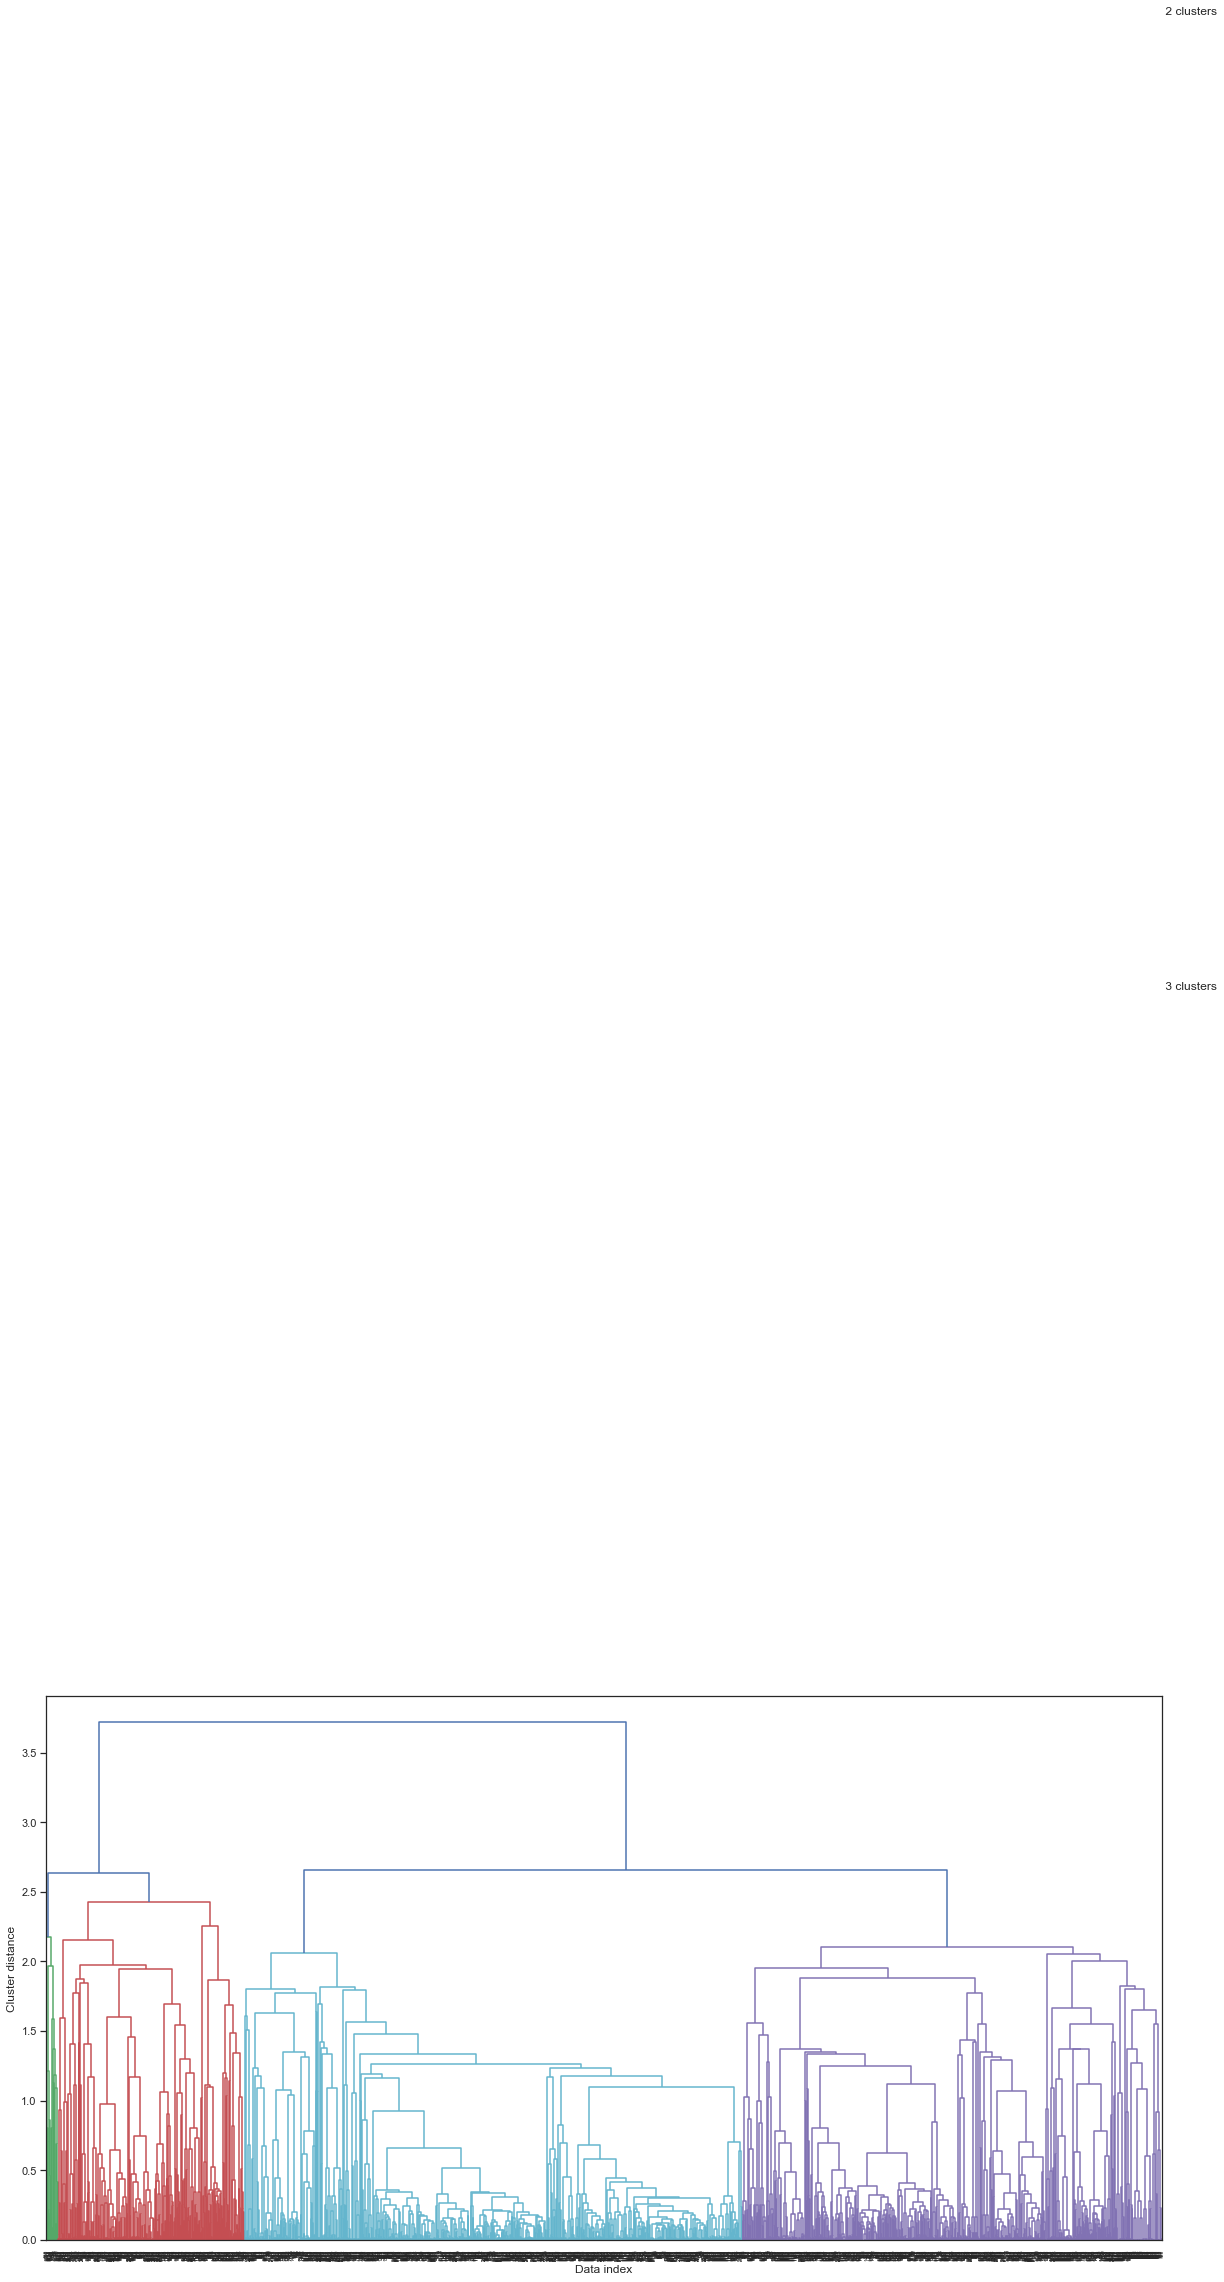

In [55]:
plt.figure(figsize=(20,10))
linkage_array = average(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

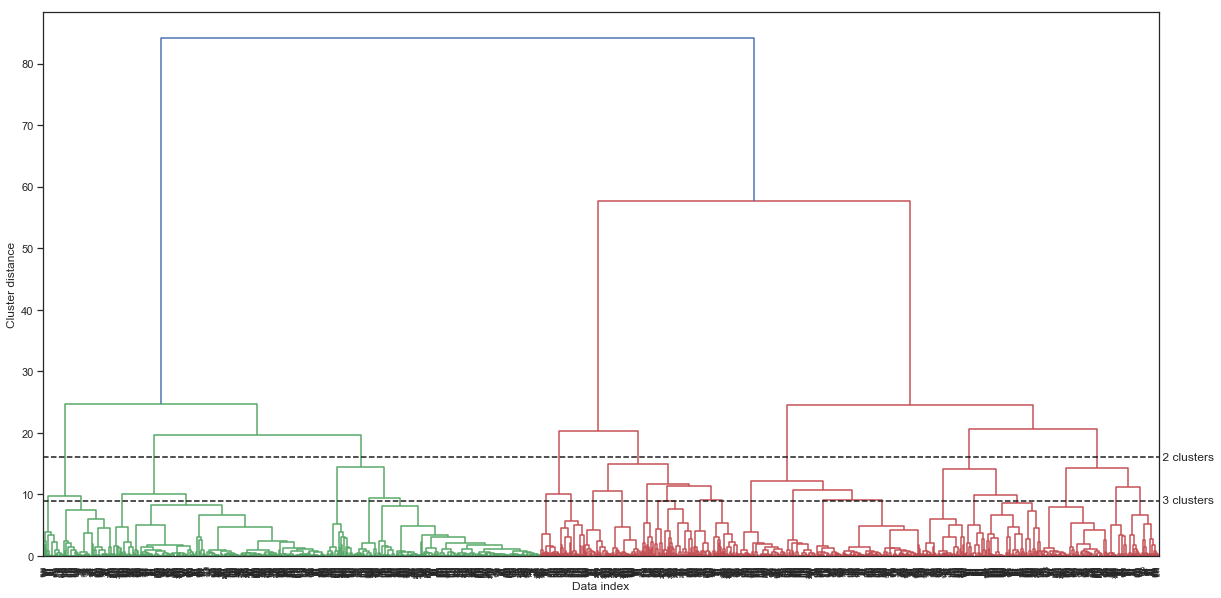

In [56]:

plt.figure(figsize=(20,10))
linkage_array = ward(df_gas_mod)

# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

In [44]:
as_kmeans = k_means.fit_predict(df_gas_mod)
as_single = agg_clust_single.fit_predict(df_gas_mod)
as_comp = agg_clust_complete.fit_predict(df_gas_mod)
as_avg = agg_clust_avg.fit_predict(df_gas_mod)
as_ward = agg_clust_ward.fit_predict(df_gas_mod)

In [45]:
labels_kmeans = labels
labels_single = agg_clust_single.labels_
labels_comp = agg_clust_complete.labels_
labels_avg = agg_clust_avg.labels_
labels_ward = agg_clust_ward.labels_

#### calinski_harabasz_score

In [46]:
metrics.calinski_harabasz_score(df_gas_mod, labels_kmeans)  

634.8090214933488

In [47]:
metrics.calinski_harabasz_score(df_gas_mod,labels_single)

197.3727850355849

In [48]:
metrics.calinski_harabasz_score(df_gas_mod,labels_ward)

636.5470408535263

In [49]:
metrics.calinski_harabasz_score(df_gas_mod,labels_avg)  

368.0248968953069

In [50]:
metrics.calinski_harabasz_score(df_gas_mod,labels_comp)  

415.18327319750193

#### silhouette_score

In [51]:
metrics.silhouette_score(df_gas_mod, labels_kmeans)

0.45717293788716035

In [52]:
metrics.silhouette_score(df_gas_mod, labels_single) 

0.23561343186388073

In [53]:
metrics.silhouette_score(df_gas_mod, labels_ward) 

0.4384215972530251

In [54]:
metrics.silhouette_score(df_gas_mod,labels_avg)  

0.3897969905342756

In [70]:
metrics.silhouette_score(df_gas_mod, labels_comp)  

0.3526313215100803

Recommender

In [56]:
df_gas_hac_ward['labels'];

In [55]:
df_for_brands_gas[df_gas_hac_ward['labels']==0][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

brand     model Torque  \
/cars/2019/bmw/x7/79153                             BMW        X7    479   
/cars/2019/cadillac/escalade/77878             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77875             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77876             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77877             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77882             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77879             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77880             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade/77881             Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77870         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77867         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77868         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77869         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77874         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77871         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77872         Cadillac  Escalade    460   
/cars/2019/cadillac/escalade-esv/77873         Cadillac  Escalade    460   
/cars/2019/dodge/durango/78101                    Dodge   Durango    390   
/cars/2019/dodge/durango/78102                    Dodge   Durango    390   
/cars/2019/gmc/yukon/78416                          GMC     Yukon    460   
/cars/2019/gmc/yukon/78417                          GMC     Yukon    383   
/cars/2019/gmc/yukon/78419                          GMC     Yukon    383   
/cars/2019/gmc/yukon/78418                          GMC     Yukon    383   
/cars/2019/gmc/yukon/78420                          GMC     Yukon    460   
/cars/2019/gmc/yukon/78421                          GMC     Yukon    383   
/cars/2019/gmc/yukon/78423                          GMC     Yukon    383   
/cars/2019/gmc/yukon/78422                          GMC     Yukon    383   
/cars/2019/gmc/yukon-xl/78408                       GMC     Yukon    460   
/cars/2019/gmc/yukon-xl/78409                       GMC     Yukon    383   
/cars/2019/gmc/yukon-xl/78411                       GMC     Yukon    383   
/cars/2019/gmc/yukon-xl/78410                       GMC     Yukon    383   
/cars/2019/gmc/yukon-xl/78412                       GMC     Yukon    460   
/cars/2019/gmc/yukon-xl/78413                       GMC     Yukon    383   
/cars/2019/gmc/yukon-xl/78415                       GMC     Yukon    383   
/cars/2019/gmc/yukon-xl/78414                       GMC     Yukon    383   
/cars/2017/infiniti/qx80/68703                 Infiniti      QX80    413   
/cars/2017/infiniti/qx80/68702                 Infiniti      QX80    413   
/cars/2017/infiniti/qx80/46816                 Infiniti      QX80    413   
/cars/2017/infiniti/qx80/68705                 Infiniti      QX80    413   
/cars/2017/infiniti/qx80/68704                 Infiniti      QX80    413   
/cars/2019/lexus/gx/78660                         Lexus        GX    329   
/cars/2019/lexus/gx/78661                         Lexus        GX    329   
/cars/2019/lexus/gx/78662                         Lexus        GX    329   
/cars/2019/lexus/lx/78663                         Lexus        LX    403   
/cars/2019/mercedes-benz/gls-class/79659  Mercedes-Benz       GLS    561   
/cars/2019/nissan/armada/79726                   Nissan    Armada    394   
/cars/2019/nissan/armada/79727                   Nissan    Armada    394   
/cars/2019/nissan/armada/79731                   Nissan    Armada    394   
/cars/2019/nissan/armada/79728                   Nissan    Armada    394   
/cars/2019/nissan/armada/79729                   Nissan    Armada    394   
/cars/2019/nissan/armada/79730                   Nissan    Armada    394   
/cars/2019/toyota/land-cruiser/78987             Toyota      Land    401   
/cars/2019/toyota/sequ

In [56]:
df_for_brands_gas[df_gas_mod_kmeans['labels']==0][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

brand         model Torque  \
/cars/2019/audi/a8/79117                           Audi            A8    487   
/cars/2019/bentley/bentayga/79130               Bentley      Bentayga    664   
/cars/2019/bentley/bentayga/79132               Bentley      Bentayga    568   
/cars/2019/bmw/5-series/77770                       BMW      5-Series    553   
/cars/2019/bmw/5-series/77773                       BMW      5-Series    480   
/cars/2019/bmw/6-series/77774                       BMW      6-Series    500   
/cars/2019/bmw/6-series/77777                       BMW      6-Series    480   
/cars/2019/bmw/6-series/77778                       BMW      6-Series    480   
/cars/2019/bmw/6-series/77779                       BMW      6-Series    590   
/cars/2019/bmw/7-series/77783                       BMW      7-Series    480   
/cars/2019/bmw/7-series/77784                       BMW      7-Series    480   
/cars/2019/bmw/7-series/77785                       BMW      7-Series    590   
/cars/2019/bmw/m5/77795                             BMW            M5    553   
/cars/2019/bmw/m5/77794                             BMW            M5    553   
/cars/2019/bmw/m6/77796                             BMW            M6    500   
/cars/2019/bmw/x5/77803                             BMW            X5    478   
/cars/2019/bmw/x6/77805                             BMW            X6    553   
/cars/2019/bmw/x6/77807                             BMW            X6    480   
/cars/2019/bmw/x7/79153                             BMW            X7    479   
/cars/2019/cadillac/ct6/77855                  Cadillac           CT6    640   
/cars/2019/genesis/g80/79268                    Genesis           G80    383   
/cars/2019/genesis/g90/79272                    Genesis           G90    383   
/cars/2019/jaguar/f-pace/79410                   Jaguar        F-Pace    502   
/cars/2019/jaguar/xe/79441                       Jaguar            XE    516   
/cars/2019/lamborghini/urus/79526           Lamborghini          Urus    626   
/cars/2019/maserati/levante/78731              Maserati       Levante    538   
/cars/2019/maserati/levante/78735              Maserati       Levante    538   
/cars/2019/maserati/quattroporte/79589         Maserati  Quattroporte    524   
/cars/2019/maserati/quattroporte/79590         Maserati  Quattroporte    524   
/cars/2019/mercedes-benz/amg-gt/79639     Mercedes-Benz           AMG    590   
/cars/2019/mercedes-benz/amg-gt/79640     Mercedes-Benz           AMG    664   
/cars/2019/mercedes-benz/c-class/78756    Mercedes-Benz             C    516   
/cars/2019/mercedes-benz/e-class/79653    Mercedes-Benz             E    627   
/cars/2019/mercedes-benz/e-class/79654    Mercedes-Benz             E    627   
/cars/2019/mercedes-benz/g-class/79657    Mercedes-Benz             G    627   
/cars/2019/mercedes-benz/g-class/79658    Mercedes-Benz             G    450   
/cars/2019/mercedes-benz/glc-class/78774  Mercedes-Benz           GLC    479   
/cars/2019/mercedes-benz/glc-class/78775  Mercedes-Benz           GLC    479   
/cars/2019/mercedes-benz/glc-class/78776  Mercedes-Benz           GLC    516   
/cars/2019/mercedes-benz/s-class/79665    Mercedes-Benz             S    664   
/cars/2019/mercedes-benz/s-class/78791    Mercedes-Benz             S    516   
/cars/2019/mercedes-benz/s-class/78793    Mercedes-Benz             S    516   
/cars/2019/porsche/cayenne/78842                Porsche       Cayenne    567   
/cars/2019/porsche/panamera/79884               Porsche      Panamera    457   
/cars/2019/porsche/panamera/79885               Porsche      Panamera    457   
/cars/2019/porsche/panamera/79886               Porsche      Panamera    567   
/cars/2019/porsche/panamera/79887               Porsche      Panamera    567   
/cars/2019/porsche/panamera/79888               Porsche      Panamera    626   
/cars/2019/porsche/panamera/79890               Porsche      Panamera    626   
/cars/2019/porsche/panamera/79889               Po

### PCA and AgglomerativeClustering

In [58]:
pca15 = PCA(n_components=15)
df_gas_transformed = pca15.fit_transform(df_gas_mod)

In [59]:
pca15.explained_variance_

array([2.18067477, 0.40634561, 0.29808329, 0.22366855, 0.1582216 ,
       0.1378909 , 0.10007716, 0.06925548, 0.05105436, 0.04180616,
       0.04120234, 0.03396822, 0.03146559, 0.02101526, 0.01905857])

In [60]:
pca15.explained_variance_ratio_

array([0.56176957, 0.1046798 , 0.07679005, 0.05761986, 0.0407599 ,
       0.03552245, 0.02578115, 0.01784109, 0.01315225, 0.0107698 ,
       0.01061425, 0.00875064, 0.00810594, 0.0054138 , 0.00490973])

In [61]:
np.cumsum(pca15.explained_variance_)

array([2.18067477, 2.58702038, 2.88510367, 3.10877222, 3.26699382,
       3.40488472, 3.50496187, 3.57421736, 3.62527171, 3.66707788,
       3.70828021, 3.74224843, 3.77371402, 3.79472928, 3.81378785])

In [62]:
np.cumsum(pca15.explained_variance_ratio_)

array([0.56176957, 0.66644937, 0.74323942, 0.80085929, 0.84161918,
       0.87714163, 0.90292278, 0.92076388, 0.93391613, 0.94468593,
       0.95530017, 0.96405082, 0.97215676, 0.97757056, 0.98248028])

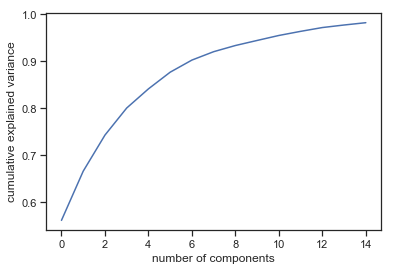

In [63]:
plt.plot(np.cumsum(pca15.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [64]:
df_gas_transformed = pd.DataFrame(df_gas_transformed, 
                                  index=df_gas_mod.index, 
                                  columns=list(map(lambda x: 'pca'+str(x), range(1,16))))
df_gas_transformed.shape

(2223, 15)

In [65]:
agg_clust_ward_pca = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_pca = agg_clust_ward_pca.fit_predict(pca15.fit_transform(df_gas_transformed))

In [66]:
df_gas_transformed['labels']=assigned_clust_ward_pca

In [67]:
df_gas_transformed.iloc[:,:-1];

In [68]:
metrics.silhouette_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

0.48536887400328516

In [69]:
metrics.calinski_harabasz_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

730.2451431576229

In [70]:
df_for_brands_gas[df_gas_transformed['labels']==2][['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

brand     model Torque  \
/cars/2018/alfa-romeo/4c/75370                     Alfa     Romeo    258   
/cars/2018/alfa-romeo/4c-spider/69017              Alfa     Romeo    258   
/cars/2019/audi/a3/79106                           Audi        A3    258   
/cars/2019/audi/a3/79104                           Audi        A3    258   
/cars/2019/audi/a3/79108                           Audi        A3    258   
/cars/2019/audi/a3-cabriolet/77679                 Audi        A3    258   
/cars/2019/audi/a3-cabriolet/77680                 Audi        A3    258   
/cars/2019/audi/a3-cabriolet/77682                 Audi        A3    258   
/cars/2019/audi/a5/77704                           Audi        A5    273   
/cars/2019/audi/a5/77702                           Audi        A5    273   
/cars/2019/audi/a5/77701                           Audi        A5    273   
/cars/2019/audi/a5/77703                           Audi        A5    273   
/cars/2019/audi/a5/77706                           Audi        A5    273   
/cars/2019/audi/a5/77705                           Audi        A5    273   
/cars/2019/audi/tt/79128                           Audi        TT    258   
/cars/2019/audi/tt/79129                           Audi        TT    354   
/cars/2019/bmw/2-series/77743                       BMW  2-Series    258   
/cars/2019/bmw/2-series/77744                       BMW  2-Series    258   
/cars/2019/bmw/2-series/77745                       BMW  2-Series    258   
/cars/2019/bmw/2-series/77746                       BMW  2-Series    258   
/cars/2019/bmw/4-series/77754                       BMW  4-Series    258   
/cars/2019/bmw/4-series/77755                       BMW  4-Series    258   
/cars/2019/bmw/4-series/77757                       BMW  4-Series    258   
/cars/2019/bmw/4-series/77758                       BMW  4-Series    258   
/cars/2019/bmw/i8/77788                             BMW        i8    420   
/cars/2019/bmw/i8/77789                             BMW        i8    420   
/cars/2019/bmw/z4/79154                             BMW        Z4    295   
/cars/2019/cadillac/ats/79166                  Cadillac       ATS    295   
/cars/2019/cadillac/ats/79167                  Cadillac       ATS    295   
/cars/2019/cadillac/ats/79168                  Cadillac       ATS    295   
...                                                 ...       ...    ...   
/cars/2019/mazda/mx-5-miata-rf/78750              Mazda      MX-5    151   
/cars/2019/mazda/mx-5-miata-rf/78751              Mazda      MX-5    151   
/cars/2019/mazda/mx-5-miata-rf/78752              Mazda      MX-5    151   
/cars/2019/mercedes-benz/c-class/78759    Mercedes-Benz         C    273   
/cars/2019/mercedes-benz/c-class/78760    Mercedes-Benz         C    273   
/cars/2019/mercedes-benz/c-class/78761    Mercedes-Benz         C    273   
/cars/2019/mercedes-benz/metris/79660     Mercedes-Benz    Metris    258   
/cars/2019/mercedes-benz/metris/79662     Mercedes-Benz    Metris    258   
/cars/2019/mercedes-benz/slc-class/78798  Mercedes-Benz       SLC    273   
/cars/2019/nissan/frontier/79747                 Nissan  Frontier    171   
/cars/2019/nissan/frontier/79732                 Nissan  Frontier    171   
/cars/2019/nissan/frontier/79749                 Nissan  Frontier    171   
/cars/2019/nissan/frontier/79750                 Nissan  Frontier    171   
/cars/2019/porsche/718/79846                    Porsche       718    280   
/cars/2019/porsche/718/79847                    Porsche       718    309   
/cars/2019/porsche/718/79848                    Porsche       718    309   
/cars/2019/porsche/718/79849                    Porsche       718    280   
/cars/2019/porsche/718/79850                    Porsche       718    309   
/cars/2019/porsche/718/79851                    Porsche       718    309   
/cars/2019/subaru/brz/79927                      Subaru       BRZ    151   
/cars/2019/subaru/brz/79928                      Subaru       BRZ    156   
/cars/2019/subaru/brz/

In [71]:
transformed_plot=df_gas_transformed.copy()

In [72]:
pca_plot = pca.fit_transform((transformed_plot.iloc[:,:-1]))

In [73]:
transformed_plot['x']=pca_plot[:,0]

In [74]:
transformed_plot['y']=pca_plot[:,1]

In [75]:
transformed_plot['z']=pca_plot[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


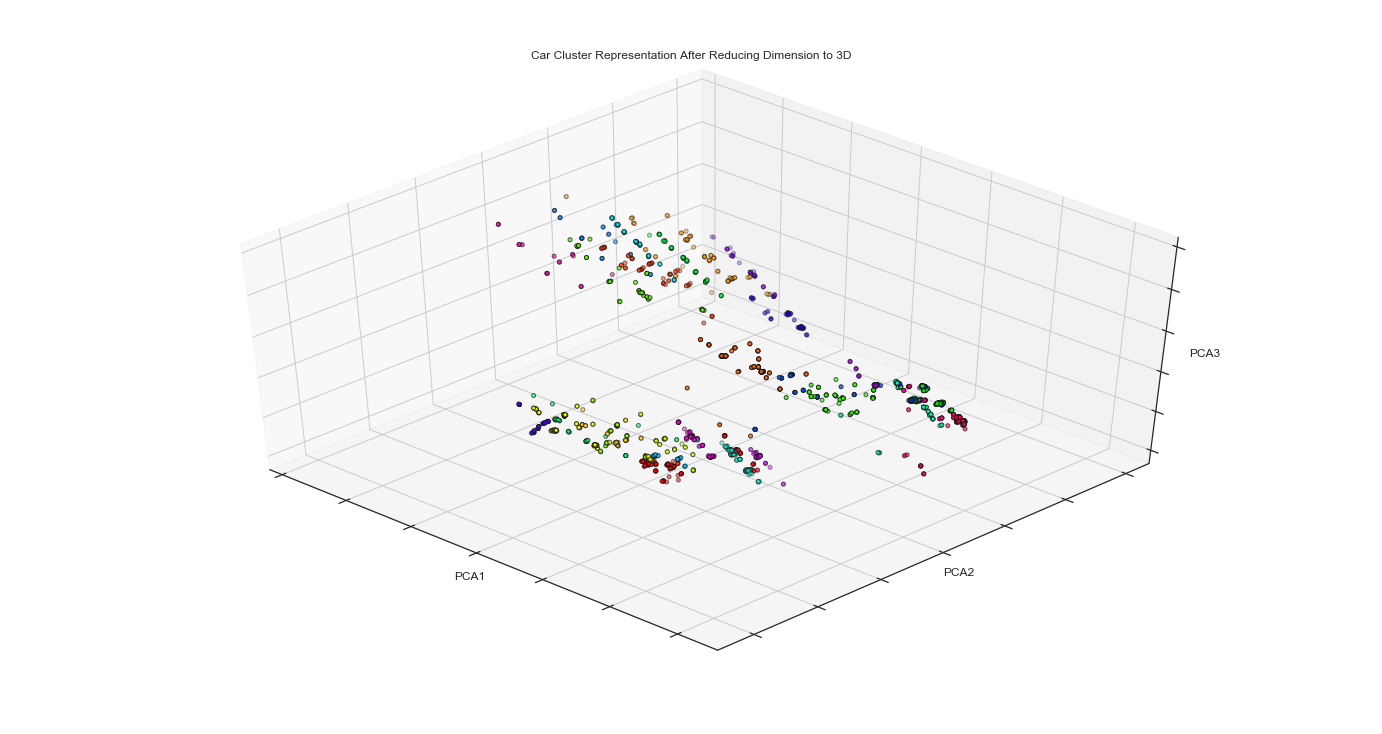

In [76]:
threed_figures(agg_clust_ward_pca, transformed_plot)

## Annoy

### TruncatedSVD

In [61]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=11)

In [62]:
df_Annoy_svd = svd.fit_transform(df_gas_mod)

In [63]:
print(np.cumsum(svd.explained_variance_ratio_))
print(svd.singular_values_)

[0.40968461 0.61621028 0.69876376 0.75899439 0.81644876 0.85216069
 0.88574629 0.91152626 0.92917066 0.94224498 0.95301177]
[176.12175421  43.79096137  26.74633793  22.98941737  22.26836021
  17.55782886  17.08826438  14.91179647  12.33754308  10.61952387
   9.63676808]


In [64]:
df_Annoy_svd.shape

(2223, 11)

In [65]:
from annoy import AnnoyIndex

f = df_Annoy_svd.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_svd.shape[0]):
    v = df_Annoy_svd[i]
    t.add_item(i, v)

t.build(15)
t.save('annoy_svd.ann')

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """


True

In [66]:
df_gas_mod

price base_engine_size  fuel_tank_capacity  \
/cars/2019/acura/ilx/79088   0.028002              2.4            0.151220   
/cars/2019/acura/ilx/79090   0.031648              2.4            0.151220   
/cars/2019/acura/ilx/79089   0.035815              2.4            0.151220   
/cars/2019/acura/ilx/79092   0.035607              2.4            0.151220   
/cars/2019/acura/ilx/79091   0.039774              2.4            0.151220   
/cars/2019/acura/mdx/77624   0.066338              3.5            0.304878   
/cars/2019/acura/mdx/77621   0.090819              3.5            0.304878   
/cars/2019/acura/mdx/77620   0.094986              3.5            0.304878   
/cars/2019/acura/mdx/77623   0.076756              3.5            0.304878   
/cars/2019/acura/mdx/77622   0.080923              3.5            0.304878   
/cars/2019/acura/mdx/77619   0.070505              3.5            0.304878   
/cars/2019/acura/mdx/77625   0.098111                3            0.302439   
/cars/2019/acura/mdx/77626   0.084048                3            0.302439   
/cars/2019/acura/mdx/77628   0.094986              3.5            0.304878   
/cars/2019/acura/mdx/77627   0.099153              3.5            0.304878   
/cars/2019/acura/mdx/77631   0.080923              3.5            0.304878   
/cars/2019/acura/mdx/77629   0.088215              3.5            0.304878   
/cars/2019/acura/mdx/77630   0.085090              3.5            0.304878   
/cars/2019/acura/nsx/79093   0.302189              3.5            0.209756   
/cars/2019/acura/rdx/77635   0.055921                2            0.246341   
/cars/2019/acura/rdx/77633   0.072797                2            0.246341   
/cars/2019/acura/rdx/77632   0.068838                2            0.246341   
/cars/2019/acura/rdx/77634   0.062588                2            0.246341   
/cars/2019/acura/rdx/77639   0.051754                2            0.246341   
/cars/2019/acura/rdx/77637   0.068630                2            0.246341   
/cars/2019/acura/rdx/77636   0.064671                2            0.246341   
/cars/2019/acura/rdx/77638   0.058421                2            0.246341   
/cars/2019/acura/rlx/77640   0.103008              3.5            0.197561   
/cars/2019/acura/rlx/79094   0.088423              3.5            0.280488   
/cars/2019/acura/tlx/77649   0.042795              2.4            0.248780   
...                               ...              ...                 ...   
/cars/2019/volvo/v90/80112   0.093736                2            0.217073   
/cars/2019/volvo/v90/80114   0.100091                2            0.151220   
/cars/2019/volvo/xc40/79062  0.052691                2            0.175610   
/cars/2019/volvo/xc40/79063  0.043211                2            0.175610   
/cars/2019/volvo/xc40/79064  0.048420                2            0.175610   
/cars/2019/volvo/xc40/70082  0.047378                2            0.175610   
/cars/2019/volvo/xc40/70083  0.052587                2            0.175610   
/cars/2019/volvo/xc60/79065  0.075818                2            0.280488   
/cars/2019/volvo/xc60/79066  0.060504                2            0.280488   
/cars/2019/volvo/xc60/79067  0.074776                2            0.280488   
/cars/2019/volvo/xc60/79068  0.071026                2            0.280488   
/cars/2019/volvo/xc60/79069  0.055712                2            0.280488   
/cars/2019/volvo/xc60/79070  0.069984                2            0.280488   
/cars/2019/volvo/xc60/79071  0.082902                2            0.280488   
/cars/2019/volvo/xc60/79072  0.067588                2            0.280488   
/cars/2019/volvo/xc60/79073  0.081860                2            0.280488   
/cars/2019/volvo/xc60/79074  0.099570                2            0.151220   
/cars/2019/volvo/xc60/79075  0.084256                2            0.151220   
/cars/2019/volvo/xc60/79076  0.098528                2            0.151220   
/cars/2019/volvo/xc90/79077  0.077589                2

In [67]:
df_gas_mod.index[100]

'/cars/2019/audi/a5/79114'

In [68]:
def nearest_car_Annoy(df, car_idx, index, n, print_output=True):
    nn = index.get_nns_by_item(car_idx, n)
    if print_output == True:
        print('Closest to %s : \n' % df.index[car_idx])
    cars = [df.index[i] for i in nn]
    if print_output == True:
        return df_for_brands_gas.loc[cars, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [69]:
def index_finder(string1,string2):
    index_list = []
    for i in df_for_brands_gas.index:
        if re.findall(str(string1).lower()+'\/'+str(string2).lower(), i):
            index_list.append(i)
    return df_for_brands_gas.loc[index_list, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [70]:
nearest_car_Annoy(df_gas_mod, 100, t, n=20)

Closest to /cars/2019/audi/a5/79114 : 



brand     model Torque  \
/cars/2019/audi/a5/79114                         Audi        A5    369   
/cars/2019/audi/a5/79113                         Audi        A5    369   
/cars/2019/audi/a5/79115                         Audi        A5    369   
/cars/2019/mercedes-benz/c-class/78753  Mercedes-Benz         C    384   
/cars/2019/audi/s5-cabriolet/77732               Audi        S5    369   
/cars/2019/audi/s5-cabriolet/77733               Audi        S5    369   
/cars/2019/mercedes-benz/c-class/78754  Mercedes-Benz         C    384   
/cars/2017/infiniti/q60-coupe/47451          Infiniti       Q60    350   
/cars/2019/audi/s5-coupe/77735                   Audi        S5    369   
/cars/2019/audi/s5-coupe/77734                   Audi        S5    369   
/cars/2019/audi/s5-coupe/77736                   Audi        S5    369   
/cars/2019/bmw/4-series/77764                     BMW  4-Series    330   
/cars/2019/bmw/4-series/77763                     BMW  4-Series    330   
/cars/2019/bmw/2-series/77750                     BMW  2-Series    369   
/cars/2017/infiniti/q60-coupe/47447          Infiniti       Q60    295   
/cars/2017/infiniti/q60-coupe/47449          Infiniti       Q60    295   
/cars/2019/porsche/911/79853                  Porsche       911    331   
/cars/2019/porsche/911/79852                  Porsche       911    331   
/cars/2019/porsche/911/79866                  Porsche       911    331   
/cars/2019/audi/a5/79112                         Audi        A5    443   

                                       Passenger Capacity   price  \
/cars/2019/audi/a5/79114                                4   52400   
/cars/2019/audi/a5/79113                                4   65100   
/cars/2019/audi/a5/79115                                4   65100   
/cars/2019/mercedes-benz/c-class/78753                  4   63650   
/cars/2019/audi/s5-cabriolet/77732                      4   35100   
/cars/2019/audi/s5-cabriolet/77733                      4   35100   
/cars/2019/mercedes-benz/c-class/78754                  4   57450   
/cars/2017/infiniti/q60-coupe/47451                     4   48700   
/cars/2019/audi/s5-coupe/77735                          4   35100   
/cars/2019/audi/s5-coupe/77734                          4   35100   
/cars/2019/audi/s5-coupe/77736                          4   35100   
/cars/2019/bmw/4-series/77764                           4   53200   
/cars/2019/bmw/4-series/77763                           4   62000   
/cars/2019/bmw/2-series/77750                           4   47800   
/cars/2017/infiniti/q60-coupe/47447                     4   39070   
/cars/2017/infiniti/q60-coupe/47449                     4   39070   
/cars/2019/porsche/911/79853                            4   98000   
/cars/2019/porsche/911/79852                            4  110300   
/cars/2019/porsche/911/79866                            4  110300   
/cars/2019/audi/a5/79112                                4   74200   

                                                                                     trim  
/cars/2019/audi/a5/79114                                         Premium 3.0 TFSI quattro  
/cars/2019/audi/a5/79113                                    Premium Plus 3.0 TFSI quattro  
/cars/2019/audi/a5/79115                                        Prestige 3.0 TFSI quattro  
/cars/2019/mercedes-benz/c-class/78753                    Class AMG C 43 4MATIC Cabriolet  
/cars/2019/audi/s5-cabriolet/77732                        Cabriolet 3.0 TFSI Premium Plus  
/cars/2019/audi/s5-cabriolet/77733                            Cabriolet 3.0 TFSI Prestige  
/cars/2019/mercedes-benz/c-class/78754                        Class AMG C 43 4MATIC Coupe  
/cars/2017/infiniti/q60-coupe/47451     Coupe Red Sport 400 - Coupe 3.0L V6 Twin-turbo...  
/cars/2019/audi/s5-coupe/77735                                     Coupe 3.0 TFSI Premium  
/cars/2019/audi/s5-coupe/77734                                Coupe 3.0 TFSI Premium Plus  
/cars/2019/audi/s5-coupe/77736 

In [71]:
nearest_car_Annoy(df_gas_mod, 1295, t, n=20)

Closest to /cars/2019/lexus/ls/79559 : 



brand     model Torque Passenger Capacity  \
/cars/2019/lexus/ls/79559           Lexus        LS    442                  5   
/cars/2019/lexus/ls/79560           Lexus        LS    442                  5   
/cars/2019/ford/taurus/78231         Ford    Taurus    350                  5   
/cars/2019/cadillac/ct6/77856    Cadillac       CT6    400                  5   
/cars/2019/ford/taurus/78226         Ford    Taurus    254                  5   
/cars/2019/ford/taurus/78229         Ford    Taurus    254                  5   
/cars/2019/cadillac/xt5/77890    Cadillac       XT5    271                  5   
/cars/2019/cadillac/xt5/77891    Cadillac       XT5    271                  5   
/cars/2019/cadillac/xt5/77889    Cadillac       XT5    271                  5   
/cars/2019/cadillac/xt5/77892    Cadillac       XT5    271                  5   
/cars/2019/dodge/charger/78092      Dodge   Charger    264                  5   
/cars/2019/chrysler/300/78063    Chrysler       300    264                  5   
/cars/2019/chrysler/300/78065    Chrysler       300    260                  5   
/cars/2019/chrysler/300/78067    Chrysler       300    260                  5   
/cars/2019/chrysler/300/78068    Chrysler       300    260                  5   
/cars/2019/cadillac/cts/77861    Cadillac       CTS    285                  5   
/cars/2019/nissan/murano/79771     Nissan    Murano    240                  5   
/cars/2019/lexus/rx/78672           Lexus        RX    267                  5   
/cars/2019/buick/lacrosse/77825     Buick  Lacrosse    268                  5   
/cars/2019/buick/lacrosse/77831     Buick  Lacrosse    268                  5   

                                 price                                trim  
/cars/2019/lexus/ls/79559        78670                          LS 500 AWD  
/cars/2019/lexus/ls/79560        84670                  LS 500 F SPORT AWD  
/cars/2019/ford/taurus/78231     42975                             SHO AWD  
/cars/2019/cadillac/ct6/77856    78195        4-Door Sedan 3.6L Luxury AWD  
/cars/2019/ford/taurus/78226     39160                         Limited AWD  
/cars/2019/ford/taurus/78229     32080                             SEL AWD  
/cars/2019/cadillac/xt5/77890    65895                 AWD 4-Door Platinum  
/cars/2019/cadillac/xt5/77891    56695           AWD 4-Door Premium Luxury  
/cars/2019/cadillac/xt5/77889    50995                   AWD 4-Door Luxury  
/cars/2019/cadillac/xt5/77892    44695                          AWD 4-Door  
/cars/2019/dodge/charger/78092   32995                             SXT AWD  
/cars/2019/chrysler/300/78063    38895                            300S AWD  
/cars/2019/chrysler/300/78065    40145                         Limited AWD  
/cars/2019/chrysler/300/78067    31495                         Touring AWD  
/cars/2019/chrysler/300/78068    31495                       Touring L AWD  
/cars/2019/cadillac/cts/77861    62195  4-Door Sedan 2.0L Turbo Luxury AWD  
/cars/2019/nissan/murano/79771   45230                        AWD Platinum  
/cars/2019/lexus/rx/78672        50620                  RX 350 F Sport AWD  
/cars/2019/buick/lacrosse/77825  47070             4-Door Sedan Avenir AWD  
/cars/2019/buick/lacrosse/77831  43470            4-Door Sedan Premium AWD

In [72]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(df_gas_mod)

In [75]:
df_plot = pd.DataFrame(X_embedded, index=df_gas_mod.index, columns = ['x','y','z'])

In [76]:
agg_clust_ward_tsne = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_tsne = agg_clust_ward_tsne.fit_predict(df_plot)

In [77]:
df_plot['labels']=assigned_clust_ward_tsne

In [78]:
import plotly.express as px
fig = px.scatter_3d(df_plot, x='x', y='y', z='z', color='labels')
fig.show()

### All Features

In [ ]:
df_gas_mod.shape

In [ ]:
from annoy import AnnoyIndex
import random

f = df_gas_mod.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_gas_mod.shape[0]):
    v = df_gas_mod.iloc[i,:]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

In [162]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

Closest to /cars/2019/audi/a4-allroad/77690 : 



brand     model Torque  \
/cars/2019/audi/a4-allroad/77690               Audi        A4    273   
/cars/2019/audi/a4-allroad/77689               Audi        A4    273   
/cars/2019/audi/a4-allroad/77691               Audi        A4    273   
/cars/2019/genesis/g70/79255                Genesis       G70    260   
/cars/2019/audi/a5-sportback/77699             Audi        A5    273   
/cars/2019/audi/a5-sportback/77698             Audi        A5    273   
/cars/2019/audi/a5-sportback/77700             Audi        A5    273   
/cars/2019/bmw/3-series/77752                   BMW  3-Series    295   
/cars/2019/kia/stinger/79516                    Kia   Stinger    260   
/cars/2019/kia/stinger/79508                    Kia   Stinger    260   
/cars/2019/mini/cooper-countryman/78812        MINI    Cooper    258   
/cars/2019/volkswagen/arteon/80033       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80032       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80031       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80034       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80029       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80035       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80025       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80026       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80023       Volkswagen    Arteon    258   

                                        Passenger Capacity  price  \
/cars/2019/audi/a4-allroad/77690                         5  38995   
/cars/2019/audi/a4-allroad/77689                         5  38995   
/cars/2019/audi/a4-allroad/77691                         5  38995   
/cars/2019/genesis/g70/79255                             5  36900   
/cars/2019/audi/a5-sportback/77699                       5  38995   
/cars/2019/audi/a5-sportback/77698                       5  38995   
/cars/2019/audi/a5-sportback/77700                       5  38995   
/cars/2019/bmw/3-series/77752                            5  42250   
/cars/2019/kia/stinger/79516                             5  41390   
/cars/2019/kia/stinger/79508                             5  35190   
/cars/2019/mini/cooper-countryman/78812                  5  37900   
/cars/2019/volkswagen/arteon/80033                       5  46210   
/cars/2019/volkswagen/arteon/80032                       5  46710   
/cars/2019/volkswagen/arteon/80031                       5  44945   
/cars/2019/volkswagen/arteon/80034                       5  43560   
/cars/2019/volkswagen/arteon/80029                       5  41795   
/cars/2019/volkswagen/arteon/80035                       5  43060   
/cars/2019/volkswagen/arteon/80025                       5  39410   
/cars/2019/volkswagen/arteon/80026                       5  38910   
/cars/2019/volkswagen/arteon/80023                       5  37645   

                                                                            trim  
/cars/2019/audi/a4-allroad/77690                        allroad 2.0 TFSI Premium  
/cars/2019/audi/a4-allroad/77689                   allroad 2.0 TFSI Premium Plus  
/cars/2019/audi/a4-allroad/77691                       allroad 2.0 TFSI Prestige  
/cars/2019/genesis/g70/79255                                   2.0T Advanced AWD  
/cars/2019/audi/a5-sportback/77699                    Sportback 2.0 TFSI Premium  
/cars/2019/audi/a5-sportback/77698               Sportback 2.0 TFSI Premium Plus  
/cars/2019/audi/a5-sportback/77700                   Sportback 2.0 TFSI Prestige  
/cars/2019/bmw/3-series/77752                           330i xDrive Sports Wagon  
/cars/2019/kia/stinger/79516                                         Premium AWD  
/cars/2019/kia/stinger/79508                                            Base AWD  
/cars/2019/mini/cooper-countryman/78812        Countryman John Cooper Works ALL4  
/cars/2019/volkswagen/arteon/80033                    SEL Premium R-Line 4MOTION  
/car

### All Features

In [ ]:
df_Annoy_pca = pca15.fit_transform(df_gas_mod)

In [ ]:
from annoy import AnnoyIndex
import random

f = df_Annoy_pca.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_pca.shape[0]):
    v = df_Annoy_pca[i]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

In [163]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

Closest to /cars/2019/audi/a4-allroad/77690 : 



brand     model Torque  \
/cars/2019/audi/a4-allroad/77690               Audi        A4    273   
/cars/2019/audi/a4-allroad/77689               Audi        A4    273   
/cars/2019/audi/a4-allroad/77691               Audi        A4    273   
/cars/2019/genesis/g70/79255                Genesis       G70    260   
/cars/2019/audi/a5-sportback/77699             Audi        A5    273   
/cars/2019/audi/a5-sportback/77698             Audi        A5    273   
/cars/2019/audi/a5-sportback/77700             Audi        A5    273   
/cars/2019/bmw/3-series/77752                   BMW  3-Series    295   
/cars/2019/kia/stinger/79516                    Kia   Stinger    260   
/cars/2019/kia/stinger/79508                    Kia   Stinger    260   
/cars/2019/mini/cooper-countryman/78812        MINI    Cooper    258   
/cars/2019/volkswagen/arteon/80033       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80032       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80031       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80034       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80029       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80035       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80025       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80026       Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80023       Volkswagen    Arteon    258   

                                        Passenger Capacity  price  \
/cars/2019/audi/a4-allroad/77690                         5  38995   
/cars/2019/audi/a4-allroad/77689                         5  38995   
/cars/2019/audi/a4-allroad/77691                         5  38995   
/cars/2019/genesis/g70/79255                             5  36900   
/cars/2019/audi/a5-sportback/77699                       5  38995   
/cars/2019/audi/a5-sportback/77698                       5  38995   
/cars/2019/audi/a5-sportback/77700                       5  38995   
/cars/2019/bmw/3-series/77752                            5  42250   
/cars/2019/kia/stinger/79516                             5  41390   
/cars/2019/kia/stinger/79508                             5  35190   
/cars/2019/mini/cooper-countryman/78812                  5  37900   
/cars/2019/volkswagen/arteon/80033                       5  46210   
/cars/2019/volkswagen/arteon/80032                       5  46710   
/cars/2019/volkswagen/arteon/80031                       5  44945   
/cars/2019/volkswagen/arteon/80034                       5  43560   
/cars/2019/volkswagen/arteon/80029                       5  41795   
/cars/2019/volkswagen/arteon/80035                       5  43060   
/cars/2019/volkswagen/arteon/80025                       5  39410   
/cars/2019/volkswagen/arteon/80026                       5  38910   
/cars/2019/volkswagen/arteon/80023                       5  37645   

                                                                            trim  
/cars/2019/audi/a4-allroad/77690                        allroad 2.0 TFSI Premium  
/cars/2019/audi/a4-allroad/77689                   allroad 2.0 TFSI Premium Plus  
/cars/2019/audi/a4-allroad/77691                       allroad 2.0 TFSI Prestige  
/cars/2019/genesis/g70/79255                                   2.0T Advanced AWD  
/cars/2019/audi/a5-sportback/77699                    Sportback 2.0 TFSI Premium  
/cars/2019/audi/a5-sportback/77698               Sportback 2.0 TFSI Premium Plus  
/cars/2019/audi/a5-sportback/77700                   Sportback 2.0 TFSI Prestige  
/cars/2019/bmw/3-series/77752                           330i xDrive Sports Wagon  
/cars/2019/kia/stinger/79516                                         Premium AWD  
/cars/2019/kia/stinger/79508                                            Base AWD  
/cars/2019/mini/cooper-countryman/78812        Countryman John Cooper Works ALL4  
/cars/2019/volkswagen/arteon/80033                    SEL Premium R-Line 4MOTION  
/car

# Function tobe Dashed

In [1]:
val1 = input("Enter your favourite car brand: ") 
val2 = input("And model: ")
index_finder(val1,val2)

Enter your favourite car brand: audi
And model: a5


NameError: name 'index_finder' is not defined

In [230]:
val3 = input("Enter desired trim index: ") 
val3_iloc = list(df_gas_mod.index).index(str(val3))
nearest_car_Annoy(df_gas_mod, val3_iloc, t, n=20)

Enter desired trim index: /cars/2019/bmw/3-series/77753
Closest to /cars/2019/bmw/3-series/77753 : 



brand     model Torque  \
/cars/2019/bmw/3-series/77753                       BMW  3-Series    330   
/cars/2019/bmw/5-series/77772                       BMW  5-Series    332   
/cars/2017/infiniti/q50/47442                  Infiniti       Q50    295   
/cars/2017/infiniti/q50/47440                  Infiniti       Q50    295   
/cars/2017/infiniti/q50/47434                  Infiniti       Q50    295   
/cars/2019/audi/a6/77707                           Audi        A6    369   
/cars/2019/audi/a6/77708                           Audi        A6    369   
/cars/2019/audi/a6/77709                           Audi        A6    369   
/cars/2019/bmw/6-series/77775                       BMW  6-Series    330   
/cars/2019/audi/q8/77724                           Audi        Q8    369   
/cars/2019/audi/q8/77722                           Audi        Q8    369   
/cars/2019/audi/q8/77723                           Audi        Q8    369   
/cars/2019/mercedes-benz/e-class/79655    Mercedes-Benz         E    369   
/cars/2017/infiniti/q50/47432                  Infiniti       Q50    350   
/cars/2019/audi/a7/77711                           Audi        A7    369   
/cars/2019/audi/a7/77710                           Audi        A7    369   
/cars/2019/audi/a7/77712                           Audi        A7    369   
/cars/2019/mercedes-benz/cls-class/79648  Mercedes-Benz       CLS    369   
/cars/2019/mercedes-benz/e-class/79652    Mercedes-Benz         E    384   
/cars/2019/bmw/x3/77797                             BMW        X3    369   

                                         Passenger Capacity  price  \
/cars/2019/bmw/3-series/77753                             5  51250   
/cars/2019/bmw/5-series/77772                             5  61250   
/cars/2017/infiniti/q50/47442                             5  26995   
/cars/2017/infiniti/q50/47440                             5  26995   
/cars/2017/infiniti/q50/47434                             5  26995   
/cars/2019/audi/a6/77707                                  5  50200   
/cars/2019/audi/a6/77708                                  5  50200   
/cars/2019/audi/a6/77709                                  5  50200   
/cars/2019/bmw/6-series/77775                             5  84500   
/cars/2019/audi/q8/77724                                  5  52400   
/cars/2019/audi/q8/77722                                  5  52400   
/cars/2019/audi/q8/77723                                  5  52400   
/cars/2019/mercedes-benz/e-class/79655                    5  59950   
/cars/2017/infiniti/q50/47432                             5  50700   
/cars/2019/audi/a7/77711                                  5  68000   
/cars/2019/audi/a7/77710                                  5  68000   
/cars/2019/audi/a7/77712                                  5  68000   
/cars/2019/mercedes-benz/cls-class/79648                  5  71700   
/cars/2019/mercedes-benz/e-class/79652                    5  72550   
/cars/2019/bmw/x3/77797                                   5  54650   

                                                                                       trim  
/cars/2019/bmw/3-series/77753                                      340i xDrive Gran Turismo  
/cars/2019/bmw/5-series/77772                                             540i xDrive Sedan  
/cars/2017/infiniti/q50/47442                     Sport - Sedan 3.0L V6 Twin-turbo AWD auto  
/cars/2017/infiniti/q50/47440              3.0t Premium - Sedan 3.0L V6 Twin-turbo AWD auto  
/cars/2017/infiniti/q50/47434             3.0t Signature Edition - Sedan 3.0L V6 Twin-tu...  
/cars/2019/audi/a6/77707                                  3.0 TFSI Premium Plus quattro AWD  
/cars/2019/audi/a6/77708                                       3.0 TFSI Premium quattro AWD  
/cars/2019/audi/a6/77709                                      3.0 TFSI Prestige quattro AWD  
/cars/2019/bmw/6-series/77775                                        640i xDrive Gran Coupe  
/cars/2019/audi/q8/77724                  